### Downloading the dataset from Kaggle

In [591]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [592]:
api.dataset_download_file('teertha/ushealthinsurancedataset', 'insurance.csv')

False

### Importing nessecary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tools.eval_measures import rmse
from statsmodels.compat import lzip

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


##### No Missing values

### Changing Data types of Sex, Smoker and Region columns to 'Category'.

In [4]:
df['sex'] = df['sex'].astype('category')
df['region'] = df['region'].astype('category')
df['smoker'] = df['smoker'].astype('category')

In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
df.describe(include = 'category')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


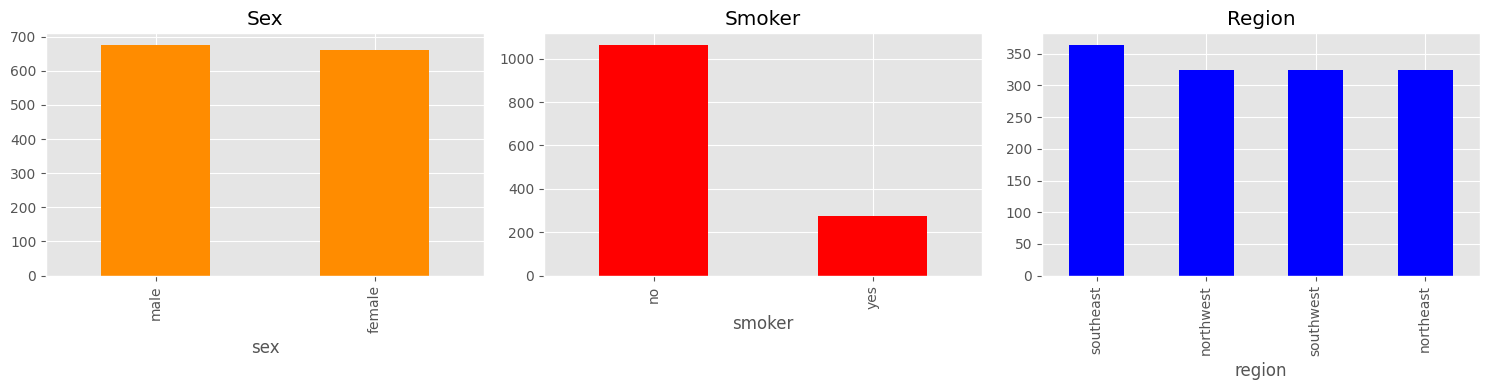

In [7]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
df['sex'].value_counts().plot(kind='bar', ax=ax[0], title='Sex', color='darkorange')
df['smoker'].value_counts().plot(kind='bar', ax=ax[1], title='Smoker', color='red')
df['region'].value_counts().plot(kind='bar', ax=ax[2], title='Region', color='blue')
plt.tight_layout()
plt.show()

### Analyzing the Relationship between target and categorical features.

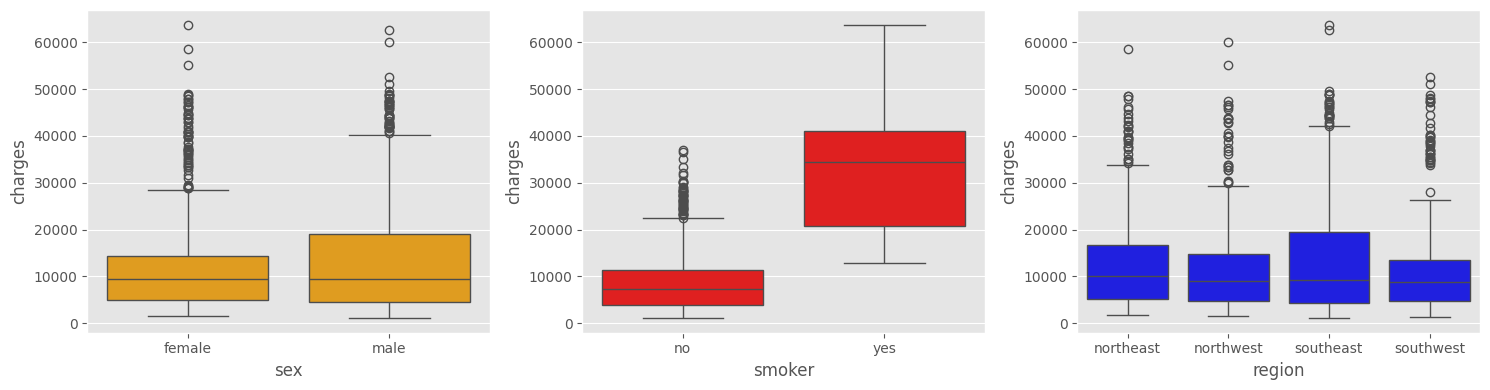

In [8]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
sns.boxplot(df, x='sex', y='charges', ax=ax[0], color='orange')
sns.boxplot(df, x='smoker', y='charges', ax=ax[1], color='red')
sns.boxplot(df, x='region', y='charges', ax=ax[2], color='blue')
plt.tight_layout()
plt.show()

### Correlation of Numerical columns --- Checking for MultiCollinearity between features

In [9]:
df_num = df.select_dtypes(np.number)
df_num.columns

Index(['age', 'bmi', 'children', 'charges'], dtype='object')

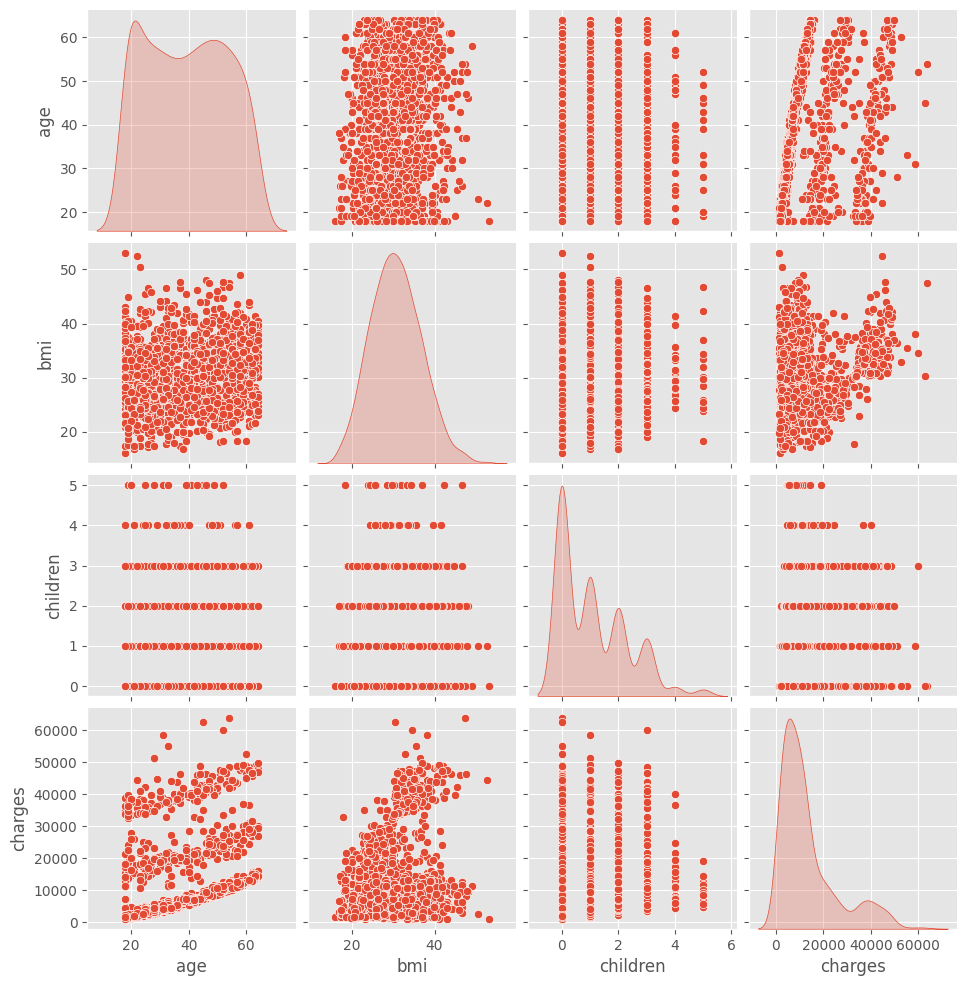

In [10]:
sns.pairplot(df_num, diag_kind='kde')
plt.show()

In [11]:
df_num.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


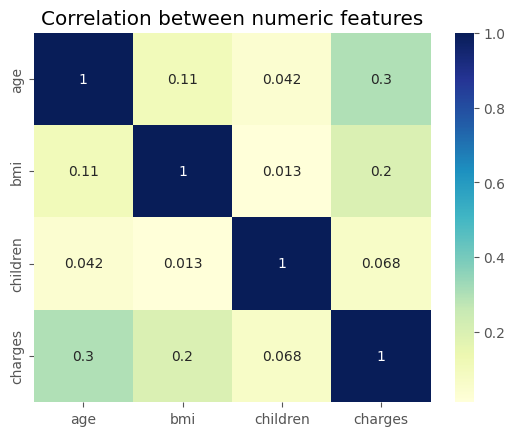

In [12]:
sns.heatmap(df_num.corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation between numeric features')
plt.show()

It can be observed that the numeric variables are less correlated with each other since all the correlation coefficients are close to zero or 0.1. It implies that there will be less multicollinearity in the data. 
                        
Recollect that one of the assumptions of linear regression is that, there should be NO Multicollinearity present in the data.

### Checking for Outliers

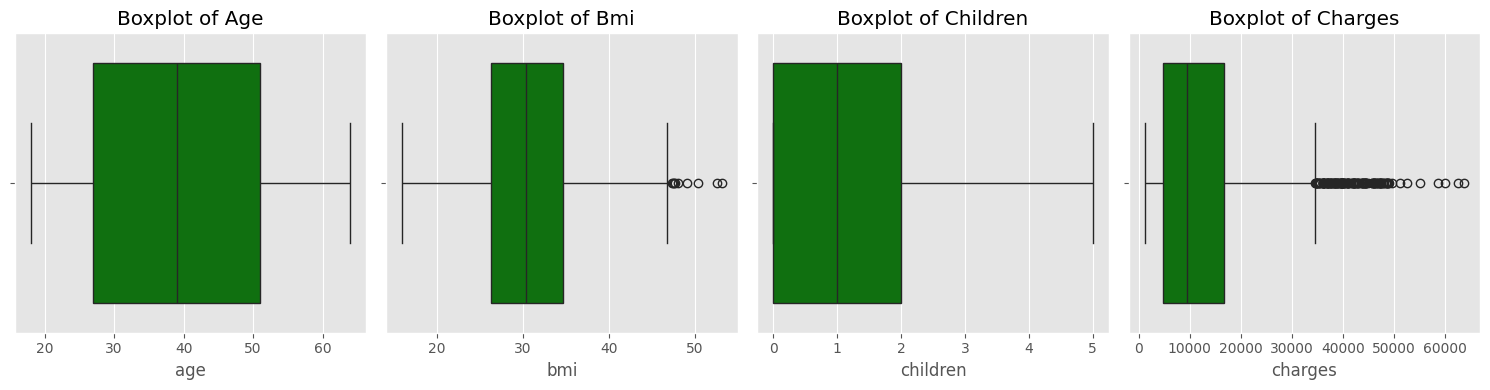

In [13]:
fig,ax = plt.subplots(1,4,figsize=(15,4))
for i,j in enumerate(df_num.columns):
    sns.boxplot(df, x=j, ax=ax[i], color='green')
    ax[i].set_title(f"Boxplot of {j.capitalize()}")
plt.tight_layout()
plt.show()

There are outliers in 'bmi' and 'charges' columns but since there are too many let's just keep them.

### Checking Normality using Wilk-Shapiro and Jarque Bera tests :-

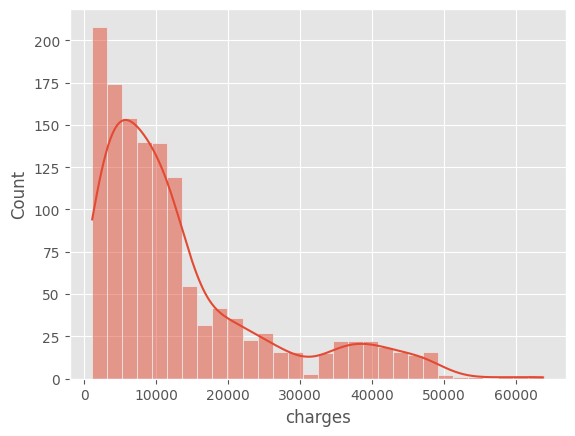

In [14]:
sns.histplot(df['charges'], kde=True)
plt.show()

As we can observe data is hugely right skewed. Let's confirm this using Wilk-Shapiro's test as well

In [15]:
from scipy.stats import shapiro
test_stat, p_value = shapiro(df['charges'])
alpha = 0.05
print("Shapiro's P-value is",p_value)
if p_value > alpha: print("We can't reject the Null Hypothesis that the distribution is Normal.")
else: print('We can reject the Null Hypothesis that the distribution is Normal. Hence distribution is not Normal.')

Shapiro's P-value is 1.1505194006561963e-36
We can reject the Null Hypothesis that the distribution is Normal. Hence distribution is not Normal.


#### Let's do a Log transformation and check again for Normality

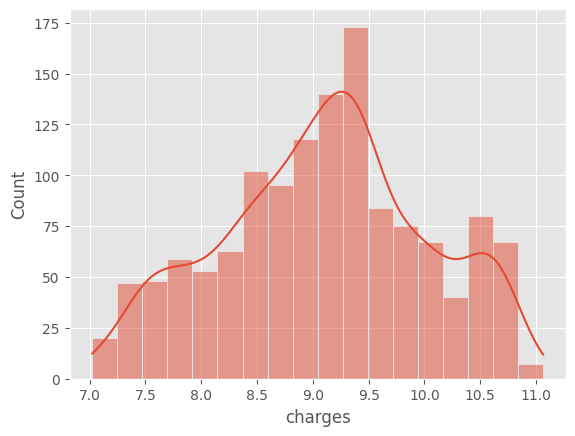

In [16]:
sns.histplot(np.log(df['charges']), kde=True)
plt.show()

Resembles and Normal curve..let's check using JB test.

In [17]:
from scipy.stats import jarque_bera
test_stat, p_value = jarque_bera(np.log(df['charges']))
alpha = 0.05
print("Jarque Bera's P-value is",p_value)
if p_value > alpha: print("We can't reject the Null Hypothesis that the distribution is Normal.")
else: print('We can reject the Null Hypothesis that the distribution is Normal. Hence distribution is not Normal.')

Jarque Bera's P-value is 4.65826510237943e-06
We can reject the Null Hypothesis that the distribution is Normal. Hence distribution is not Normal.


Jarque-Bera rejects it. Note that in real life it might be very tough for the data to adhere to all assumptions your algorithm needs.

### One-Hot Encoding on Category columns

In [18]:
df = pd.get_dummies(df, columns=['sex'], drop_first=True)
df = pd.get_dummies(df, columns=['smoker'], drop_first=True)
df = pd.get_dummies(df, columns=['region'], drop_first=True)

In [19]:
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


### Converting Boolean columns to Binary 'int'

In [20]:
df_dummy = df.copy()

In [21]:
for i in df_dummy.columns:
    if df_dummy[i].dtype == 'bool':
        df_dummy[i] = np.where(df_dummy[i] == True, 1, 0)

In [22]:
df_dummy.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


# Linear Regression

### Simple Linear Model using OLS (Ordinary Least Sqaure) method.

##### Taking 1 independent feature.

In [23]:
X = sm.add_constant(df_dummy['age'])
y = df_dummy['charges']

In [24]:
X.head()

,const,age
0,1.0,19
1,1.0,18
2,1.0,28
3,1.0,33
4,1.0,32


In [25]:
# Creating the model
SLR = sm.OLS(y,X).fit()
print(SLR.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     131.2
Date:                Fri, 23 Feb 2024   Prob (F-statistic):           4.89e-29
Time:                        10:12:16   Log-Likelihood:                -14415.
No. Observations:                1338   AIC:                         2.883e+04
Df Residuals:                    1336   BIC:                         2.884e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3165.8850    937.149      3.378      0.0

### Multiple features Linear Regression

In [26]:
X = sm.add_constant(df_dummy.drop('charges', axis=1))
y = df_dummy[['charges']]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [28]:
SLR = sm.OLS(y_train, X_train).fit()
print(SLR.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     356.2
Date:                Fri, 23 Feb 2024   Prob (F-statistic):          1.27e-276
Time:                        10:12:16   Log-Likelihood:                -9477.0
No. Observations:                 936   AIC:                         1.897e+04
Df Residuals:                     927   BIC:                         1.902e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.104e+04   1172.364  

### Finding insignificant features

In [29]:
SLR.pvalues

const                3.594046e-20
age                  2.944787e-60
bmi                  3.705717e-20
children             3.437391e-02
sex_male             4.781365e-01
smoker_yes          6.125578e-259
region_northwest     5.971764e-01
region_southeast     1.043686e-01
region_southwest     1.260428e-01
dtype: float64

In [30]:
for i,j in SLR.pvalues.to_dict().items():
    if j > 0.05:
        print(f"{i} -----> Insignificant")
    else:
        print(f"{i} -----> Significant")

const -----> Significant
age -----> Significant
bmi -----> Significant
children -----> Significant
sex_male -----> Insignificant
smoker_yes -----> Significant
region_northwest -----> Insignificant
region_southeast -----> Insignificant
region_southwest -----> Insignificant


### Model Accuracy

In [31]:
y_pred = SLR.predict(X_test)

In [32]:
print('RMSE =',rmse(y_test, y_pred.to_frame())[0])
print('R Sqaured =',SLR.rsquared)
print('Adjusted R Squared=',SLR.rsquared_adj)

RMSE = 6063.122656850453
R Sqaured = 0.7545557492633161
Adjusted R Squared= 0.7524375680271851


### Detecting AutoCorrelation

Autocorrelation (also called serial correlation) refers to the degree of correlation between the values of the same variables across different observations in the data. One of the assumptions of the linear regression is that there should not be autocorrelation.

The Durbin Watson Test is a measure of autocorrelation in residuals from the regression analysis.
Autocorrelation being present typically indicates that we are missing some information that should be captured by the model.

$H_0$ : There is no auto-correlation in residuals.

$H_a$ : There is auto-correlation in residuals.

The test stats value is nearly equal to 2*(1-r), Here r is the sample autocorrelation of the residuals. If r == 0, then we can say that no serial correlation and the test statistic equals 2. This statistic always is between 0 and 4.
If the test statistic is near to or closer to 0 then there will be more evidence to say that positive serial correlation. and if the test stats value is near to or closer to 4, then we can say that more evidence for negative serial correlation.

Our model has test stats value of 1.94, we can conclude that there is no auto-correlation.

### Detecting Heteroskedasticity

Heteroskedasticity is a systematic change in the spread of the residuals over the range of measured values. One of the assumptions of the linear regression is that there should not be Heteroskedasticity.

Breusch-Pagan is the test for detecting heteroskedasticity:

The null and alternate hypothesis of Breusch-Pagan test is as follows:

$H_0$: The residuals are homoskedastic

$H_a$: The residuals are not homoskedastic

In [33]:
# create vector of result parmeters
name = ['f-value','p-value']           

# perform Breusch-Pagan test using het_breushpagan()
# compute residuals using 'resid'
# 'exog' returns the independent variables in the model alng with the intercept
test = sms.het_breuschpagan(SLR.resid, SLR.model.exog)

# print the output
# use 'lzip' to zip the column names and test results
lzip(name, test) 

[('f-value', 82.82686324842673), ('p-value', 1.3166464848716053e-14)]

We observe that p-value is less than 0.05 and thus reject the null hypothesis. We conclude that there is heteroskedasticity present in the data. In real life it might not be possible to meet all the assumptions of linear regression.

### Checking Normality of Residuals

#### Q-Q Plot

In [34]:
residuals = y_test['charges'] - y_pred
residuals

559     -2963.885841
1087    -1534.666280
1020    -3775.355752
460     -2816.357926
802      1473.742818
            ...     
323     -4657.752978
1268    -1981.280583
134      -817.158175
1274   -10022.249940
876     16633.666834
Length: 402, dtype: float64

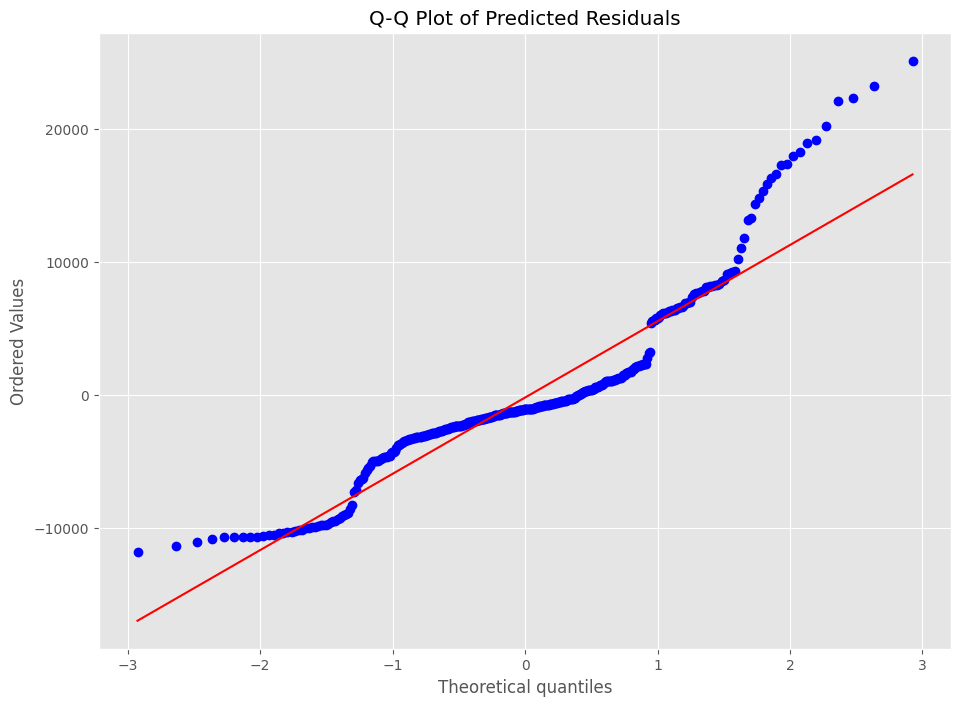

In [35]:
from scipy.stats import probplot
plt.figure(figsize=(11,8))
probplot(residuals, plot=plt)
plt.title('Q-Q Plot of Predicted Residuals')
plt.show()

Using this plot, we can infer that the residuals do not come from a normal distribution. This is expected as our target variable is not normally distributed.

## Linear Regression with Interaction (OLS)

#### Let's combine 2 significant columns and build a Regression Model.

In [36]:
df_dummy['bmi_interact_smoker'] = df_dummy['bmi']*df_dummy['smoker_yes']

In [37]:
df_dummy.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_interact_smoker
0,19,27.900,0,16884.92400,0,1,0,0,1,27.9
1,18,33.770,1,1725.55230,1,0,0,1,0,0.0
2,28,33.000,3,4449.46200,1,0,0,1,0,0.0
3,33,22.705,0,21984.47061,1,0,1,0,0,0.0
4,32,28.880,0,3866.85520,1,0,1,0,0,0.0


In [38]:
X = df_dummy.drop('charges', axis=1)
y = df_dummy[['charges']]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [40]:
SLR = sm.OLS(y_train, X_train).fit()
print(SLR.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                              1290.
Date:                Fri, 23 Feb 2024   Prob (F-statistic):                        0.00
Time:                        10:12:17   Log-Likelihood:                         -9281.7
No. Observations:                 936   AIC:                                  1.858e+04
Df Residuals:                     927   BIC:                                  1.862e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Adjusted R-Squared increased drastically, Durbin-Watson stat is 2 i.e., no auto-correlation.

### Model Accuracy

In [41]:
y_pred = SLR.predict(X_test)

In [42]:
print('RMSE =',rmse(y_test, y_pred.to_frame())[0])
print('R Sqaured =',SLR.rsquared)
print('Adjusted R Squared=',SLR.rsquared_adj)

RMSE = 4714.206562983881
R Sqaured = 0.9260337504049515
Adjusted R Squared= 0.9253156314768443


RMSE decreased and R Squared increased. Hence the interaction feature has positively contributed to performance of the model. 

In [43]:
df_dummy.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_interact_smoker
0,19,27.900,0,16884.92400,0,1,0,0,1,27.9
1,18,33.770,1,1725.55230,1,0,0,1,0,0.0
2,28,33.000,3,4449.46200,1,0,0,1,0,0.0
3,33,22.705,0,21984.47061,1,0,1,0,0,0.0
4,32,28.880,0,3866.85520,1,0,1,0,0,0.0


---

## ML Pipeline

In [44]:
# Keeping the interaction feature as well
X = df_dummy.drop('charges', axis=1)
y = df_dummy[['charges']]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [46]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1003, 9), (335, 9), (1003, 1), (335, 1))

### Scaling Train and Test Sets

In [47]:
from sklearn.preprocessing import StandardScaler

model = StandardScaler()
X_train_scaled= pd.DataFrame(model.fit_transform(X_train), columns=X_train.columns)
X_test_scaled= pd.DataFrame(model.fit_transform(X_test), columns=X_test.columns)

In [48]:
X_test_scaled.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_interact_smoker
0,0.421642,-0.939625,0.773687,-1.015038,-0.504660,-0.555512,-0.675664,-0.55091,-0.490789
1,-0.217499,-0.173516,-0.882448,-1.015038,-0.504660,1.800141,-0.675664,-0.55091,-0.490789
2,1.770941,-0.669234,-0.882448,-1.015038,1.981532,1.800141,-0.675664,-0.55091,1.582181
3,0.492658,-0.849495,1.601754,0.985184,-0.504660,1.800141,-0.675664,-0.55091,-0.490789
4,-1.424766,0.126919,-0.882448,0.985184,1.981532,1.800141,-0.675664,-0.55091,1.970406


In [49]:
y_standard_scaling = StandardScaler()
y_train_scaled = y_standard_scaling.fit(y_train)
y_test_scaled = y_standard_scaling.fit(y_test)

In [50]:
y_train_scaled= pd.DataFrame(y_standard_scaling.transform(y_train), columns=y_train.columns)
y_test_scaled= pd.DataFrame(y_standard_scaling.transform(y_test), columns=y_test.columns)

## Stochastic Gradient Descent - SGD

Gradient Descent is an optimization technique in machine learning. It is an iterative method which is used to find the values of the parameters of a function that minimizes the cost function. The parameters are initially specified and from that, Gradient Descent is run in an iterative way to find the optimal values of the parameters.

For gradient decent we use the complete dataset to get the optimal in a less noisy or less random manner. But the problem arises when our datasets get really huge, say you have a million samples in your dataset, it becomes computationally very expensive to perform. This problem is solved by Stochastic Gradient Descent. In SGD, it uses only a single sample to perform each iteration. The sample is randomly shuffled and selected for performing the iteration. Here, since only one sample from the dataset is chosen at random for each iteration, the path taken by the algorithm to reach the optima is usually noisier than your typical Gradient Descent algorithm. But that doesn’t matter because the path taken by the algorithm is not considered, as long as we reach the optima with significantly shorter training time.

### Linear Regression with SGD

In [51]:
# It's actually Mini Batch Gradient Descent, train data is divided in batches and least cost function line is outputted.
from sklearn.linear_model import SGDRegressor, LinearRegression

model_SGDRegg = SGDRegressor().fit(X_train_scaled, y_train_scaled)

In [52]:
pd.DataFrame(model_SGDRegg.predict(X_test_scaled), columns=y_test_scaled.columns)

,charges
0,-0.280237
1,-0.492486
2,1.840205
3,-0.246699
4,1.185841
...,...
330,0.007185
331,0.065879
332,-0.536199
333,1.027220


In [53]:
# Predictions
y_pred = pd.DataFrame(y_standard_scaling.inverse_transform(pd.DataFrame(model_SGDRegg.predict(X_test_scaled), 
                                                               columns=y_test_scaled.columns)), 
                                                               columns=y_test.columns)
y_pred.head()

,charges
0,9835.503084
1,7228.279141
2,35882.535087
3,10247.469187
4,27844.465270


In [54]:
print('Mean Square Error =',mean_squared_error(y_test, y_pred))
print('Root Mean Square Error =',rmse(y_test, y_pred)[0])
print('R2 Score =',r2_score(y_test, y_pred))
print('Adjusted R2 Score =',1 - (1 - r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)- X_test.shape[1]-1))

Mean Square Error = 25850776.73922056
Root Mean Square Error = 5084.365913191197
R2 Score = 0.8286792929668716
Adjusted R2 Score = 0.8239350272336465


In [55]:
score_card = pd.DataFrame(columns=['Model Name','R-Squared','Adj R-Squared','RMSE'])

In [56]:
score_card.loc[len(score_card.index)] = ['Linear Regression SGD','0.823','0.828','5020.273']

In [57]:
score_card

,Model Name,R-Squared,Adj R-Squared,RMSE
0,Linear Regression SGD,0.823,0.828,5020.273


## Fit Linear Regression using SGD with GridSearchCV

In [58]:
# Below are the parameters of SGDRegressor(). Using GridSearchCV() we need to find optimal parameters for best possible fit.
SGDRegressor().get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [59]:
10.0 ** -np.arange(1, 7)

array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])

In [60]:
from sklearn.model_selection import GridSearchCV

# alpha is regularization term usually in the range 10.0**-np.arange(1,7).
# this will generate different alpha values like 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06

# loss="squared_loss": Ordinary least squares, 

# "l2": L2 norm penalty on coefficients (ridge regression), 
# "l1": L1 norm penalty on coefficients(lasso regression), "elasticnet": Convex combination of L2 and L1    
   
# The learning rate can be either constant or gradually decaying 

param_grid = { 'alpha': 10.0 ** -np.arange(1, 7), 
        
               'loss': ['squared_error'], 
    
               'penalty': ['l2', 'l1', 'elasticnet'],
    
               'learning_rate': ['constant', 'optimal', 'invscaling']
}
model_Grid_SDG = GridSearchCV(model_SGDRegg, param_grid)
model_Grid_SDG.fit(X_train_scaled, y_train_scaled)

GridSearchCV(estimator=SGDRegressor(),
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                         'learning_rate': ['constant', 'optimal', 'invscaling'],
                         'loss': ['squared_error'],
                         'penalty': ['l2', 'l1', 'elasticnet']})

In [61]:
print(model_Grid_SDG.best_estimator_)

SGDRegressor(alpha=1e-06, learning_rate='constant', penalty='elasticnet')


In [62]:
# Also let's check other parameters of SDGRegressor()
print('Best tol:', model_Grid_SDG.best_estimator_.tol)
print('Best eta0:', model_Grid_SDG.best_estimator_.eta0)

Best tol: 0.001
Best eta0: 0.01


In [63]:
# Creating the model with these new hyper parameters
model_SGDRegg_opt = SGDRegressor(alpha=0.001, learning_rate='constant', penalty='l1', tol=0.001, eta0=0.01).fit(X_train_scaled, y_train_scaled)

In [64]:
# Predictions
y_pred = pd.DataFrame(y_standard_scaling.inverse_transform(pd.DataFrame(model_SGDRegg_opt.predict(X_test_scaled), 
                                                               columns=y_test_scaled.columns)), 
                                                               columns=y_test.columns)
y_pred.head()

,charges
0,10854.685683
1,7290.422981
2,32752.683231
3,12042.969165
4,28746.474822


In [65]:
print('Mean Square Error =',mean_squared_error(y_test, y_pred))
print('Root Mean Square Error =',rmse(y_test, y_pred)[0])
print('R2 Score =',r2_score(y_test, y_pred))
print('Adjusted R2 Score =',1 - (1 - r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)- X_test.shape[1]-1))

Mean Square Error = 22651930.793232426
Root Mean Square Error = 4759.404457832138
R2 Score = 0.8498789866815011
Adjusted R2 Score = 0.8457217893896042


In [66]:
score_card.loc[len(score_card.index)] = ['GridSearchCV Optimized LR SGD', 0.847, 0.843, 4796.139]

In [67]:
score_card

,Model Name,R-Squared,Adj R-Squared,RMSE
0,Linear Regression SGD,0.823,0.828,5020.273
1,GridSearchCV Optimized LR SGD,0.847,0.843,4796.139


## Feature Selection

### Forward Selection - Empty model is created and one by one features are added upto the limit set.

In [68]:
# k_features can take in number, range of numbers and 'best'
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plt_sfs

model = LinearRegression()
sfs1 = sfs(model, k_features=5, forward=True, verbose=2, cv=5, scoring='r2')
sfs1 = sfs1.fit(X_train, y_train)

sfs1.get_metric_dict()


[2024-02-23 10:12:26] Features: 1/5 -- score: 0.6991500611083008
[2024-02-23 10:12:27] Features: 2/5 -- score: 0.8024772799758233
[2024-02-23 10:12:27] Features: 3/5 -- score: 0.827195980005237
[2024-02-23 10:12:27] Features: 4/5 -- score: 0.8293908295188979
[2024-02-23 10:12:27] Features: 5/5 -- score: 0.8298441822648226

{1: {'feature_idx': (8,),
  'cv_scores': array([0.73517323, 0.75436704, 0.68548401, 0.59309852, 0.7276275 ]),
  'avg_score': 0.6991500611083008,
  'feature_names': ('bmi_interact_smoker',),
  'ci_bound': 0.07403819653354002,
  'std_dev': 0.05760423222397206,
  'std_err': 0.028802116111986027},
 2: {'feature_idx': (0, 8),
  'cv_scores': array([0.82748853, 0.8616398 , 0.78683721, 0.71028495, 0.8261359 ]),
  'avg_score': 0.8024772799758233,
  'feature_names': ('age', 'bmi_interact_smoker'),
  'ci_bound': 0.0666111459626472,
  'std_dev': 0.05182573455849902,
  'std_err': 0.025912867279249508},
 3: {'feature_idx': (0, 4, 8),
  'cv_scores': array([0.84130479, 0.89111795, 0.80952251, 0.74400383, 0.85003083]),
  'avg_score': 0.827195980005237,
  'feature_names': ('age', 'smoker_yes', 'bmi_interact_smoker'),
  'ci_bound': 0.0630704527649402,
  'std_dev': 0.04907095496169783,
  'std_err': 0.024535477480848916},
 4: {'feature_idx': (0, 2, 4, 8),
  'cv_scores': array([0.84657765, 0.89060515, 0.811

<Figure size 5000x5000 with 0 Axes>

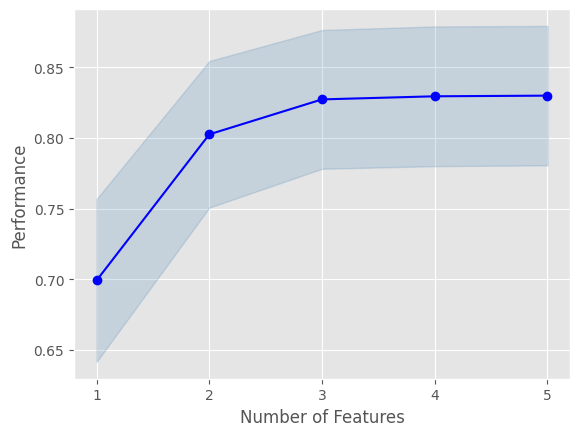

In [69]:
plt.figure(figsize=(50,50))
fig1 = plt_sfs(sfs1.get_metric_dict(), kind= 'std_dev') 
plt.show()

In [70]:
result = pd.DataFrame(sfs1.get_metric_dict()).T
result

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(8,)","[0.7351732328332539, 0.754367040269368, 0.6854...",0.69915,"(bmi_interact_smoker,)",0.074038,0.057604,0.028802
2,"(0, 8)","[0.827488528151767, 0.861639803901767, 0.78683...",0.802477,"(age, bmi_interact_smoker)",0.066611,0.051826,0.025913
3,"(0, 4, 8)","[0.8413047875456297, 0.8911179469014264, 0.809...",0.827196,"(age, smoker_yes, bmi_interact_smoker)",0.06307,0.049071,0.024535
4,"(0, 2, 4, 8)","[0.8465776452693567, 0.8906051459224683, 0.811...",0.829391,"(age, children, smoker_yes, bmi_interact_smoker)",0.063492,0.049399,0.0247
5,"(0, 2, 4, 7, 8)","[0.8471552351241021, 0.8901339916127431, 0.812...",0.829844,"(age, children, smoker_yes, region_southwest, ...",0.063374,0.049307,0.024654


In [71]:
important_features_forward = list(result.loc[5]['feature_names'])
important_features_forward

['age', 'children', 'smoker_yes', 'region_southwest', 'bmi_interact_smoker']

### Backward Elimination - Full model is created with all the features and one by one features are eliminated 

In [72]:
model = LinearRegression()
sfs2 = sfs(model, k_features=5, forward=False, verbose=2, cv=5, scoring='r2')
sfs2 = sfs2.fit(X_train, y_train)

sfs2.get_metric_dict()


[2024-02-23 10:12:28] Features: 8/5 -- score: 0.8299092655516054
[2024-02-23 10:12:29] Features: 7/5 -- score: 0.8299864177975161
[2024-02-23 10:12:29] Features: 6/5 -- score: 0.8299613300684889
[2024-02-23 10:12:29] Features: 5/5 -- score: 0.8298441822648226

{9: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8),
  'cv_scores': array([0.84889782, 0.88869129, 0.81135053, 0.74741444, 0.85227823]),
  'avg_score': 0.8297264621296065,
  'feature_names': ('age',
   'bmi',
   'children',
   'sex_male',
   'smoker_yes',
   'region_northwest',
   'region_southeast',
   'region_southwest',
   'bmi_interact_smoker'),
  'ci_bound': 0.061548977576934324,
  'std_dev': 0.047887195575916496,
  'std_err': 0.023943597787958248},
 8: {'feature_idx': (0, 2, 3, 4, 5, 6, 7, 8),
  'cv_scores': array([0.84976329, 0.8885219 , 0.81184983, 0.74732998, 0.85208132]),
  'avg_score': 0.8299092655516054,
  'feature_names': ('age',
   'children',
   'sex_male',
   'smoker_yes',
   'region_northwest',
   'region_southeast',
   'region_southwest',
   'bmi_interact_smoker'),
  'ci_bound': 0.06155109278429918,
  'std_dev': 0.047888841279106906,
  'std_err': 0.02394442063955345},
 7: {'feature_idx': (0, 2, 4, 5, 6, 7, 8),
  'cv_scores': array([0.84874799, 0.88892092, 0.81293691, 0.74

<Figure size 5000x5000 with 0 Axes>

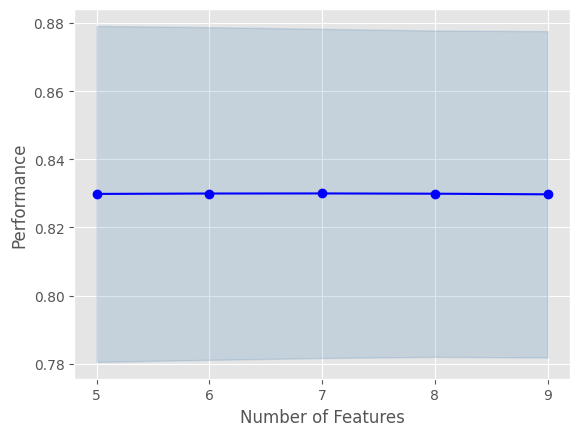

In [73]:
plt.figure(figsize=(50,50))
fig1 = plt_sfs(sfs2.get_metric_dict(), kind= 'std_dev') 
plt.show()

In [74]:
result = pd.DataFrame(sfs2.get_metric_dict()).T
result

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)","[0.8488978195848138, 0.8886912918507746, 0.811...",0.829726,"(age, bmi, children, sex_male, smoker_yes, reg...",0.061549,0.047887,0.023944
8,"(0, 2, 3, 4, 5, 6, 7, 8)","[0.8497632925831942, 0.8885219035631791, 0.811...",0.829909,"(age, children, sex_male, smoker_yes, region_n...",0.061551,0.047889,0.023944
7,"(0, 2, 4, 5, 6, 7, 8)","[0.8487479891169906, 0.8889209211835258, 0.812...",0.829986,"(age, children, smoker_yes, region_northwest, ...",0.062085,0.048304,0.024152
6,"(0, 2, 4, 6, 7, 8)","[0.8479603773484391, 0.8905447300355497, 0.812...",0.829961,"(age, children, smoker_yes, region_southeast, ...",0.062745,0.048817,0.024409
5,"(0, 2, 4, 7, 8)","[0.8471552351241021, 0.8901339916127431, 0.812...",0.829844,"(age, children, smoker_yes, region_southwest, ...",0.063374,0.049307,0.024654


In [75]:
important_features_backward = list(result.loc[5]['feature_names'])
important_features_backward

['age', 'children', 'smoker_yes', 'region_southwest', 'bmi_interact_smoker']

##### The 5 features extracted from both the selections is same.

### Exhaustive Feature Selection - Goes through all the combinations to give out the top k features which result in best fit.

In [76]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

efs = EFS(LinearRegression(), min_features=1, max_features=5, scoring='r2', cv=5, n_jobs=-1,)
efs.fit(X_train,y_train)

Features: 381/381

ExhaustiveFeatureSelector(estimator=LinearRegression(),
                          feature_groups=[[0], [1], [2], [3], [4], [5], [6],
                                          [7], [8]],
                          max_features=5, n_jobs=-1, scoring='r2')

In [77]:
efs.best_feature_names_

('age', 'children', 'smoker_yes', 'region_southwest', 'bmi_interact_smoker')

In [78]:
efs.best_score_

0.8298441822648226

##### So, these are the best features which achieve around 83% score.

### Creating a model with these features:

In [79]:
model = sm.OLS(y_train, X_train[important_features_forward]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              2410.
Date:                Fri, 23 Feb 2024   Prob (F-statistic):                        0.00
Time:                        10:12:43   Log-Likelihood:                         -9957.1
No. Observations:                1003   AIC:                                  1.992e+04
Df Residuals:                     998   BIC:                                  1.995e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [80]:
y_pred = model.predict(X_test[important_features_forward])
y_pred = y_pred.to_frame()

In [81]:
print('Mean Square Error =',mean_squared_error(y_test, y_pred))
print('Root Mean Square Error =',rmse(y_test, y_pred)[0])
print('R2 Score =',r2_score(y_test, y_pred))
print('Adjusted R2 Score =',1 - (1 - r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)- X_test.shape[1]-1))

Mean Square Error = 22911587.39338556
Root Mean Square Error = 4786.604996590544
R2 Score = 0.8481581659582862
Adjusted R2 Score = 0.8439533151694387


In [82]:
score_card.loc[len(score_card.index)] = ['LR with Features Forward/Backward/Exhaustive Selection', 0.848, 0.844, 4786.604]

In [83]:
score_card

,Model Name,R-Squared,Adj R-Squared,RMSE
0,Linear Regression SGD,0.823,0.828,5020.273
1,GridSearchCV Optimized LR SGD,0.847,0.843,4796.139
2,LR with Features Forward/Backward/Exhaustive S...,0.848,0.844,4786.604


#### $R^2$ and Adjusted $R^2$ have improved and RMSE decreased for the final model.

## Regularization

In [84]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

### 1. Ridge Regularization

#### Setting Regularization parameter $\alpha$ = 1

In [85]:
ridge = Ridge(alpha=1)
ridge.fit(X_train[important_features_forward], y_train)

Ridge(alpha=1)

In [86]:
y_pred = ridge.predict(X_test[important_features_forward])
y_pred = pd.Series(y_pred.ravel())

In [87]:
print('Mean Square Error =',mean_squared_error(y_test, y_pred))
print('Root Mean Square Error =',rmse(y_test, y_pred)[0])
print('R2 Score =',r2_score(y_test, y_pred))
print('Adjusted R2 Score =',1 - (1 - r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)- X_test.shape[1]-1))

Mean Square Error = 22366048.832159426
Root Mean Square Error = 12586.748801802625
R2 Score = 0.851773610591379
Adjusted R2 Score = 0.8476688798077556


In [88]:
score_card.loc[len(score_card.index)] = ['Ridge Model with alpha=1', 0.851, 0.847, 12586.488]

#### Setting Regularization parameter $\alpha$ = 2

In [89]:
ridge = Ridge(alpha=2)
ridge.fit(X_train[important_features_forward], y_train)

Ridge(alpha=2)

In [90]:
y_pred = ridge.predict(X_test[important_features_forward])
y_pred = pd.Series(y_pred.ravel())

In [91]:
print('Mean Square Error =',mean_squared_error(y_test, y_pred))
print('Root Mean Square Error =',rmse(y_test, y_pred)[0])
print('R2 Score =',r2_score(y_test, y_pred))
print('Adjusted R2 Score =',1 - (1 - r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)- X_test.shape[1]-1))

Mean Square Error = 22345152.936021168
Root Mean Square Error = 12592.207949075862
R2 Score = 0.8519120938461227
Adjusted R2 Score = 0.8478111979833999


In [92]:
score_card.loc[len(score_card.index)] = ['Ridge Model with alpha=2', 0.852, 0.847, 12592.207]

#### Let's try to find the optimal $\alpha$ using GridSearchCV

In [93]:
param_grid = {'alpha': [1e-15, 1e-10, 1e-8, 1e-5, 1e-2, 1e-1, 0.1, 1, 5, 10, 30]}
gscv = GridSearchCV(Ridge(), param_grid, cv=10)
gscv.fit(X_train[important_features_forward], y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.01, 0.1, 0.1,
                                   1, 5, 10, 30]})

In [94]:
gscv.best_params_

{'alpha': 0.1}

In [95]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train[important_features_forward], y_train)

Ridge(alpha=0.1)

In [96]:
y_pred = ridge.predict(X_test[important_features_forward])
y_pred = pd.Series(y_pred.ravel())

In [97]:
print('Mean Square Error =',mean_squared_error(y_test, y_pred))
print('Root Mean Square Error =',rmse(y_test, y_pred)[0])
print('R2 Score =',r2_score(y_test, y_pred))
print('Adjusted R2 Score =',1 - (1 - r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)- X_test.shape[1]-1))

Mean Square Error = 22467418.794462703
Root Mean Square Error = 12580.77162324667
R2 Score = 0.851101802011354
Adjusted R2 Score = 0.8469784672978222


In [98]:
score_card.loc[len(score_card.index)] = ['Ridge Model with alpha=2', 0.851, 0.847, 12580.771]

### 2. Lasso Regularization

In [99]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train[important_features_forward], y_train)

Lasso(alpha=0.1)

In [100]:
y_pred = lasso.predict(X_test[important_features_forward])
y_pred = pd.Series(y_pred.ravel())

In [101]:
print('Mean Square Error =',mean_squared_error(y_test, y_pred))
print('Root Mean Square Error =',rmse(y_test, y_pred)[0])
print('R2 Score =',r2_score(y_test, y_pred))
print('Adjusted R2 Score =',1 - (1 - r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)- X_test.shape[1]-1))

Mean Square Error = 22484901.749526545
Root Mean Square Error = 12580.108397154285
R2 Score = 0.8509859373217634
Adjusted R2 Score = 0.8468593940475968


In [102]:
score_card.loc[len(score_card.index)] = ['Lasso Model with alpha=0.1', 0.851, 0.846, 12580.108]

### 3. Elastic Net Regularization

In [103]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.01)
enet.fit(X_train[important_features_forward], y_train)

ElasticNet(alpha=0.1, l1_ratio=0.01)

In [104]:
y_pred = enet.predict(X_test[important_features_forward])
y_pred = pd.Series(y_pred.ravel())

In [105]:
print('Mean Square Error =',mean_squared_error(y_test, y_pred))
print('Root Mean Square Error =',rmse(y_test, y_pred)[0])
print('R2 Score =',r2_score(y_test, y_pred))
print('Adjusted R2 Score =',1 - (1 - r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)- X_test.shape[1]-1))

Mean Square Error = 24664260.619380902
Root Mean Square Error = 12651.709169300742
R2 Score = 0.8365426845627121
Adjusted R2 Score = 0.8320161742890642


In [106]:
score_card.loc[len(score_card.index)] = ['Elastic Net with alpha=0.1 and l1_ratio=0.01', 0.836, 0.832, 12651.709]

In [107]:
score_card

,Model Name,R-Squared,Adj R-Squared,RMSE
0,Linear Regression SGD,0.823,0.828,5020.273
1,GridSearchCV Optimized LR SGD,0.847,0.843,4796.139
2,LR with Features Forward/Backward/Exhaustive S...,0.848,0.844,4786.604
3,Ridge Model with alpha=1,0.851,0.847,12586.488
4,Ridge Model with alpha=2,0.852,0.847,12592.207
5,Ridge Model with alpha=2,0.851,0.847,12580.771
6,Lasso Model with alpha=0.1,0.851,0.846,12580.108
7,Elastic Net with alpha=0.1 and l1_ratio=0.01,0.836,0.832,12651.709


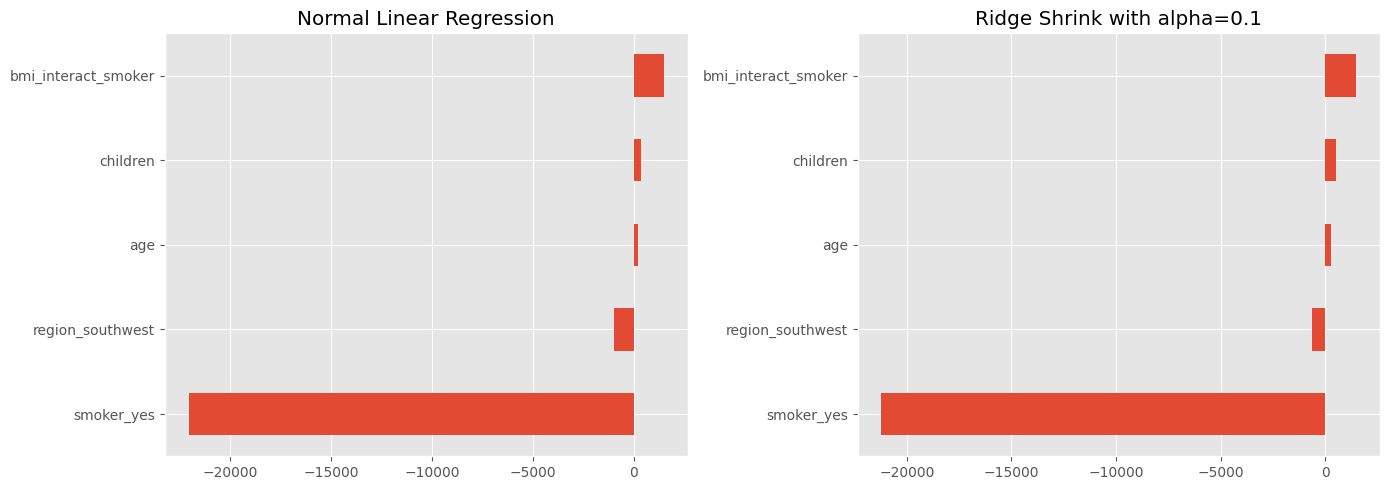

In [108]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
model.params.sort_values().plot(kind='barh', ax=ax[0], title='Normal Linear Regression')
pd.Series(ridge.coef_.ravel(), index=ridge.feature_names_in_).sort_values().plot(kind='barh', ax=ax[1], title='Ridge Shrink with alpha=0.1')

plt.tight_layout()
plt.show()

#### Notice that coefficients have slightly suppressed in Ridge. Same can be observed with Lasso below.

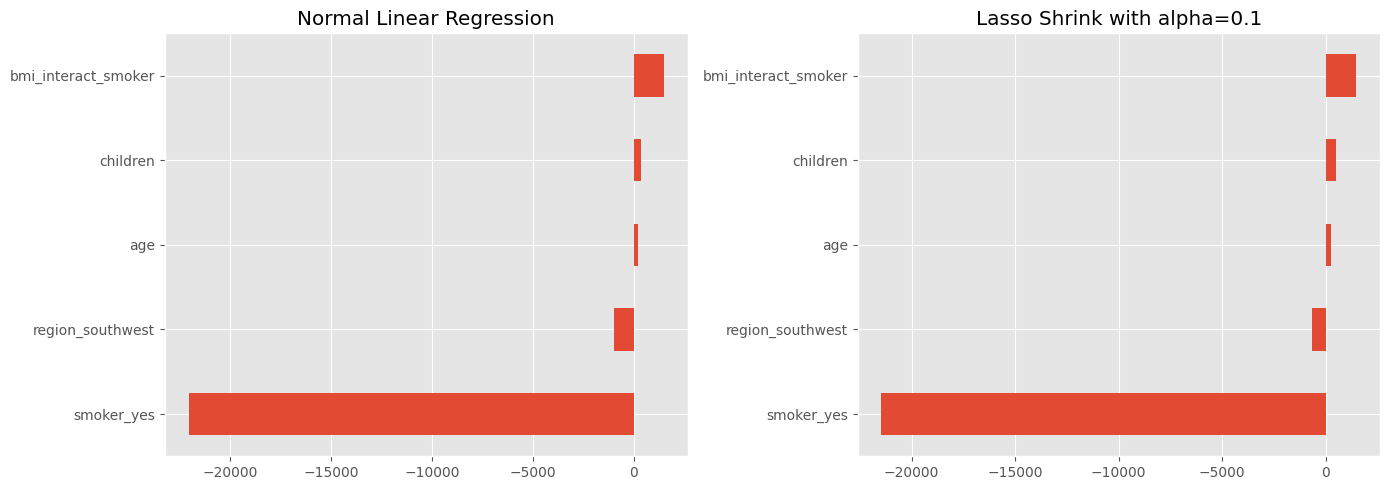

In [109]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
model.params.sort_values().plot(kind='barh', ax=ax[0], title='Normal Linear Regression')
pd.Series(lasso.coef_.ravel(), index=lasso.feature_names_in_).sort_values().plot(kind='barh', ax=ax[1], title='Lasso Shrink with alpha=0.1')

plt.tight_layout()
plt.show()

## THE END